# Imports and Constraints

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import category_encoders as ce
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator

# Defines

In [12]:
def load_data() -> pd.Series:
    csv = pd.read_csv('result.csv', sep=",")
    return csv

def del_nans(nans_perc):
    global csv, nans
    na = csv.isna().sum()
    del_na = na[na >= nans_perc*len(csv)]
    csv = csv.drop(del_na.index.values, axis=1)
    nans = nans_ctr()
    
def nans_ctr() -> pd.Series:
    return csv.isna().sum()

def unique_ctr() -> pd.Series():
    unique = pd.Series()
    for col in list(csv_org):
        if(csv.columns.contains(col) and (col != 'train')):
            unique.at[col] = len(csv[col].unique())
    return unique

def val_types() -> pd.Series():
    val_type = pd.Series()
    for col in list(csv_org):
        if not csv.columns.contains(col) or col == 'train':
            continue
        if csv[col].dtype == np.float64:
            val_type.at[col] = np.float64
        elif csv[col].dtype == np.int64:
            val_type.at[col] = np.int64
        elif csv[col].dtype == np.int32:
            val_type.at[col] = np.int32
        elif csv[col].dtype == bool:
            val_type.at[col] = bool
        elif csv[col].dtype == object:
            val_type.at[col] = object
        else:
            print(f"No common value type found in val_types() - {csv[col].dtype}")
    return val_type

def stat(f):
    nans = nans_ctr()
    unique = unique_ctr()
    val_type = val_types()
    print(f"min: {csv[f].min()}")
    print(f"max: {csv[f].max()}")
    print(f"nans: {nans[f]}")
    print(f"unique: {unique[f]}")
    print(f"val_type: {val_type[f]}")
    print(f"vals per class: {round((len(csv)-nans[f])/unique[f],2)}")
    
def plot(data, sort=False, log=True, small=False, fontsize=7):
    if small:
        figsize = (8,4)
    else:
        figsize = (20,10)
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    if sort:
        ax = df.sort_values(by=0, ascending=False).plot(kind='bar', logy = log, figsize=figsize, legend=False)
    else:
        ax = df.plot(kind='bar', logy = log, figsize=figsize, legend=False)
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.show()
    
def threshold_factorization(data, *t_list) -> pd.Series():
    letter_counts = Counter(data)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df = df.sort_values(by=0, ascending=False)
    t_list = (df.values[0].item()+1,) + t_list + (0,)
    out = data.copy()
    for i in tqdm(range(1,len(t_list)),desc="Progress",leave=False):
        idx = df[(df>t_list[i]).values & (df<=t_list[i-1]).values].index
        for j in tqdm(idx,leave=False):
            out.loc[out == j] = i
    return out

def factorize(data) -> pd.Series():
    series = data.copy()
    labels, _ = pd.factorize(series)
    series = labels[:len(series)]
    return series

def cast(data, lower_t, upper_t) -> pd.Series():
    data = data.sort_values()
    data[data<lower_t] = lower_t
    data[data>upper_t] = upper_t
    return data

def standarize(df) ->pd.Series():
    return round((df-df.min())/(df.max()-df.min()),4)

def one_hot_encoding(f):
    global csv
    ohe = ce.OneHotEncoder(cols = [f], handle_unknown='ignore', use_cat_names=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)
    
def binary_encoding(f):
    global csv
    ohe = ce.BinaryEncoder(cols = [f], handle_unknown='ignore',drop_invariant=True)
    csv[f] = csv[f].fillna(-1)
    new_features = ohe.fit_transform(csv[f].to_frame())
    csv = csv.drop([f],axis=1)
    csv = pd.concat([csv,new_features],axis=1)  
def delete(f):
    global csv
    csv[f] = csv_org[f]
    csv = csv.drop(f, axis=1)

# Data Loading

In [36]:
csv = load_data()
csv_org = csv.copy()
nans = nans_ctr()
unique = unique_ctr()
val_type = val_types()
# del_nans(0.99)
print("Max NaNs in column left: ", max(nans))
print("Columns left after Nans removed: ", len(csv.columns))

C:\Users\Mateusz\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (190,191) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Max NaNs in column left:  4285
Columns left after Nans removed:  221


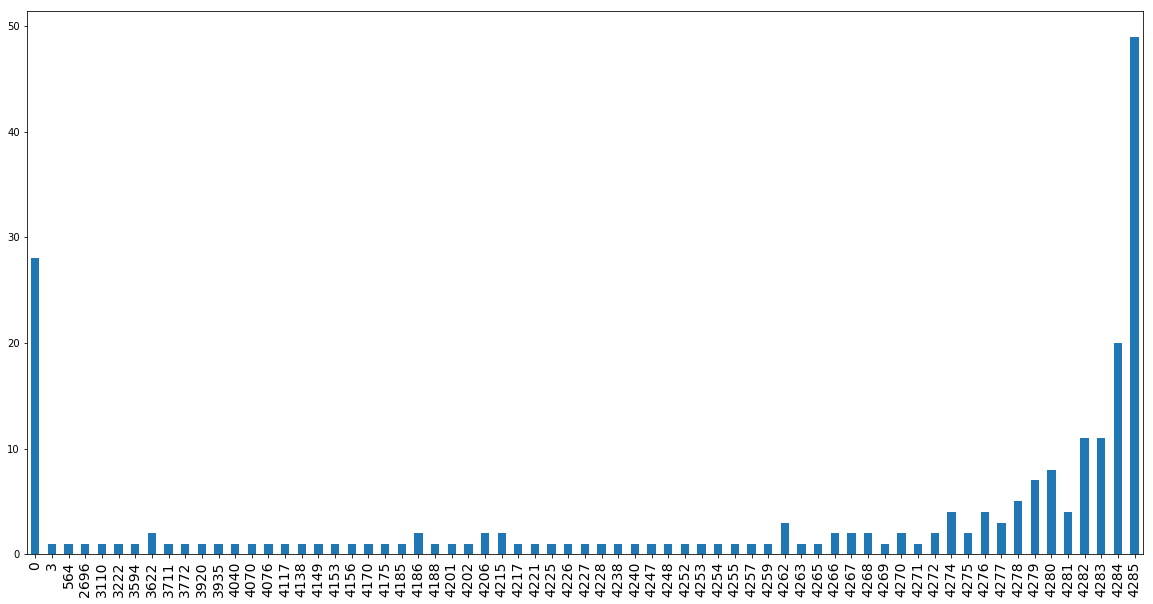

NameError: name 'head' is not defined

In [39]:
plot(nans.sort_values(),log=False,fontsize=14)
len(nans)

nans.plot.kde()

In [40]:
csv.head()

,Unnamed: 0,name,description,createdAt,diskUsage,forkCount,squashMergeAllowed,pushedAt,isArchived,isDisabled,...,Web Ontology Language,DIGITAL Command Language,SMT,DM,Terra,Handlebars,Liquid,SaltStack,Hy,POV-Ray SDL
0,0,dawn-bench-entries,DAWNBench: An End-to-End Deep Learning Benchma...,2017-11-29T02:10:47Z,383,41,True,2019-05-08T04:02:45Z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,SevenLanguages,Projects from Seven Languages in Seven Weeks,2010-12-30T14:50:03Z,104,0,True,2011-10-10T14:00:15Z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,tfjs-layers-1,TensorFlow.js high-level layers API,2018-04-20T13:47:34Z,1904,0,True,2018-07-31T08:49:21Z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,keras,Deep Learning for humans,2018-05-23T20:05:46Z,11170,0,True,2018-05-25T17:20:42Z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,lisp-koans,Common Lisp Koans is a language learning exerc...,2013-05-15T04:07:12Z,118,457,True,2019-04-27T00:54:55Z,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [549]:
f = 'Var230'
delete(f)

In [550]:
f = 'Var229'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [551]:
f = 'Var228'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=1]) = 2
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [552]:
f = 'Var227'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=1]) = 2
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [553]:
f = 'Var226'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=5]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [554]:
f = 'Var225'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
(csv[f][csv[f]==2]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [555]:
f = 'Var224'
delete(f)

In [557]:
f = 'Var223'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# (csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

In [558]:
f = 'Var222'
delete(f)

In [559]:
f = 'Var221'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=1]) = 0
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [560]:
f = 'Var220'
delete(f)

In [561]:
f = 'Var219'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [562]:
f = 'Var219'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=0]) = 1
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [563]:
f = 'Var218'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

In [564]:
f = 'Var217'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
csv[f] = threshold_factorization(csv[f],3)
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

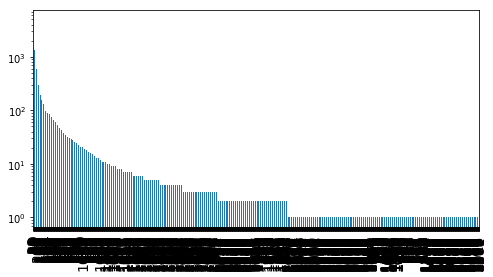

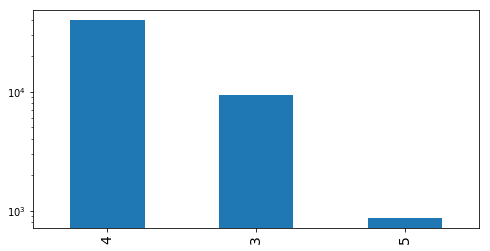

In [12]:
f = 'Var216'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(-1)
csv[f] = factorize(csv[f])
csv[f] = threshold_factorization(csv[f],100,10,1)
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=True,fontsize=14,small=True)

In [566]:
f = 'Var215'
delete(f)

In [567]:
f = 'Var214'
delete(f)

In [568]:
f = 'Var213'
delete(f)

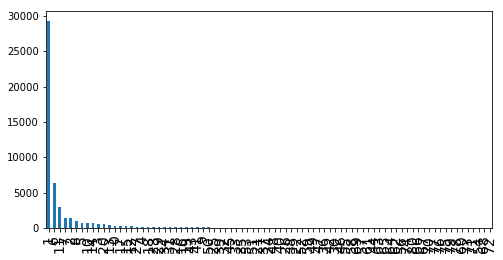

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


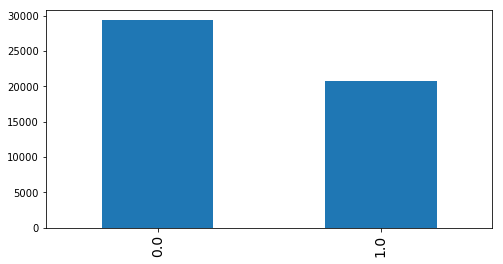

In [5]:
f = 'Var212'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14,small=True)
(csv[f][csv[f]!=1]) = 2
csv[f] = standarize(csv[f])
plot(csv[f],sort=True,log=False,fontsize=14, small=True)

In [570]:
f = 'Var211'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
csv[f] = standarize(csv[f])
# plot(csv[f],sort=True,log=False,fontsize=14)

In [571]:
f = 'Var210'
delete(f)

In [572]:
f = 'Var209'
delete(f)

In [573]:
f = 'Var208'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# plot(csv[f],sort=True,log=False)
csv[f] = standarize(csv[f])

In [574]:
f = 'Var207'
delete(f)

In [575]:
f = 'Var206'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
(csv[f][csv[f]!=2]) = 1
csv[f] = standarize(csv[f])
# # plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [576]:
f = 'Var205'
delete(f)

In [577]:
f = 'Var204'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
(csv[f][csv[f] == 1])=3
(csv[f][csv[f] == 11])=3
(csv[f][csv[f] !=3])=2
csv[f] = standarize(csv[f])
# # plot(csv[f],sort=True,log=False,fontsize=14)

C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Mateusz\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [578]:
f = 'Var203'
delete(f)

In [579]:
f = 'Var202'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
csv[f] = threshold_factorization(csv[f],10)
# plot(csv[f],sort=True,log=True)
csv[f] = standarize(csv[f])

In [580]:
f = 'Var201'
delete(f)

In [581]:
f = 'Var200'
delete(f)

In [582]:
f = 'Var199'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
print(len(csv[f][(csv[f]==0)]))
csv[f] = threshold_factorization(csv[f],200,100,1)
csv[f] = standarize(csv[f])
# # plot(csv[f],sort=True,log=True)

370


In [583]:
f = 'Var198'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
print(len(csv[f][(csv[f]==0)]))
csv[f] = threshold_factorization(csv[f],2800,1000,30)
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

4441


In [584]:
f = 'Var197'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
csv[f] = threshold_factorization(csv[f],10000,1000,100)
# plot(csv[f],sort=True,log=True)
csv[f] = standarize(csv[f])

In [585]:
f = 'Var196'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
# plot(csv[f],sort=True,log=True)
csv[f] = standarize(csv[f])

In [586]:
f = 'Var195'
delete(f)

In [587]:
f = 'Var194'
delete(f)

In [588]:
f = 'Var193'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
# # plot(csv[f],sort=True,log=False)
csv[f] = standarize(csv[f])

In [589]:
f = 'Var192'
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = factorize(csv[f])
csv[f] = threshold_factorization(csv[f],220,150,30)
# # plot(csv[f],sort=True,log=False)
csv[f] = standarize(csv[f])

In [590]:
f = 'Var191'
delete(f)

In [591]:
f = 'Var190'
delete(f)

In [592]:
f = 'Var189'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

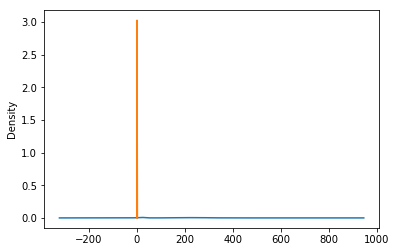

In [6]:
f = 'Var188'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
ax = csv[f].plot.kde()
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()

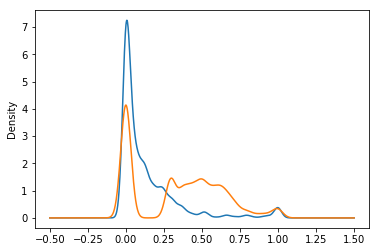

In [7]:
f = 'Var187'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
csv[f].plot.kde()

In [595]:
f = 'Var186'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [596]:
f = 'Var185'
delete(f)

In [597]:
f = 'Var184'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [598]:
f = 'Var183'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [599]:
f = 'Var182'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [600]:
f = 'Var181'
delete(f)

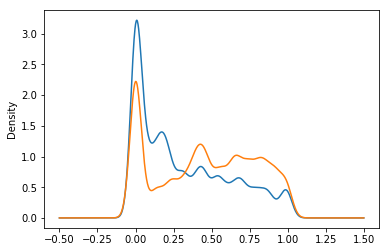

In [14]:
f = 'Var180'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [602]:
f = 'Var179'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [603]:
f = 'Var178'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/5))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [604]:
f = 'Var177'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [605]:
f = 'Var176'
delete(f)

In [606]:
f = 'Var175'
delete(f)

In [607]:
f = 'Var174'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [608]:
f = 'Var173'
delete(f)

In [609]:
f = 'Var172'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [610]:
f = 'Var171'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [611]:
f = 'Var170'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [612]:
f = 'Var169'
delete(f)


In [613]:
f = 'Var168'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [614]:
f = 'Var167'
delete(f)

In [615]:
f = 'Var166'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [616]:
f = 'Var165'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [617]:
f = 'Var164'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [618]:
f = 'Var163'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()



In [619]:
f = 'Var162'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [620]:
f = 'Var161'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [621]:
f = 'Var160'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [622]:
f = 'Var159'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [623]:
f = 'Var158'
delete(f)


In [624]:
f = 'Var157'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [625]:
f = 'Var156'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [626]:
f = 'Var155'
delete(f)

In [627]:
f = 'Var154'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [628]:
f = 'Var153'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [629]:
f = 'Var152'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()


In [630]:
f = 'Var151'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [631]:
f = 'Var150'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [632]:
f = 'Var149'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()


In [633]:
f = 'Var148'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [634]:
f = 'Var147'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [635]:
f = 'Var146'
delete(f)

In [636]:
f = 'Var145'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [637]:
f = 'Var144'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [638]:
f = 'Var143'
delete(f)

In [639]:
f = 'Var142'
delete(f)

In [640]:
f = 'Var141'
delete(f)

In [641]:
f = 'Var140'
delete(f)

In [642]:
f = 'Var139'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [643]:
f = 'Var138'
delete(f)

In [644]:
f = 'Var137'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [645]:
f = 'Var136'
delete(f)

In [646]:
f = 'Var135'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [647]:
f = 'Var134'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [648]:
f = 'Var133'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [649]:
f = 'Var132'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [650]:
f = 'Var131'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [651]:
f = 'Var130'
delete(f)

In [652]:
f = 'Var129'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [653]:
f = 'Var128'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [654]:
f = 'Var127'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [655]:
f = 'Var126'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [656]:
f = 'Var125'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/4))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [657]:
f = 'Var124'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [658]:
f = 'Var123'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [659]:
f = 'Var122'
delete(f)

In [660]:
f = 'Var121'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [661]:
f = 'Var120'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [662]:
f = 'Var119'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [663]:
f = 'Var118'
delete(f)

In [664]:
f = 'Var117'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [665]:
f = 'Var116'
delete(f)

In [666]:
f = 'Var115'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [667]:
f = 'Var114'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [668]:
f = 'Var113'
delete(f)

In [669]:
f = 'Var112'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [670]:
f = 'Var111'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [671]:
f = 'Var110'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()

In [672]:
f = 'Var109'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [673]:
f = 'Var108'
delete(f)

In [674]:
f = 'Var107'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()


In [675]:
f = 'Var106'
delete(f)

In [676]:
f = 'Var105'
delete(f)

In [677]:
f = 'Var104'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],2100)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()


In [678]:
f = 'Var103'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
# csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
# csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()


In [679]:
f = 'Var101'
delete(f)

In [680]:
f = 'Var100'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10)
# plot(csv[f].sort_values(),log=False,small=True)
# # ax = csv[f].plot.kde()

In [681]:
f = 'Var99'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()
# plot(csv[f].sort_values(),log=False,small=True)

In [682]:
f = 'Var98'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# # ax = csv[f].plot.kde()

In [683]:
f = 'Var97'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])

In [684]:
f = 'Var96'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [685]:
f = 'Var95'
delete(f)

In [686]:
f = 'Var94'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],10000)
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [687]:
f = 'Var93'
delete(f)

In [688]:
f = 'Var91'
# print(stat(f))
csv[f] = csv_org[f].copy()
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# # ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [689]:
f = 'Var90'
delete(f)

In [690]:
f = 'Var89'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [691]:
f = 'Var88'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [692]:
f = 'Var87'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [693]:
f = 'Var86'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [694]:
f = 'Var85'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],20000)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [695]:
f = 'Var84'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = threshold_factorization(csv[f],20000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [696]:
f = 'Var83'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.93))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],2)
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [697]:
f = 'Var82'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# csv[f] = threshold_factorization(csv[f],2)
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [698]:
f = 'Var81'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
csv[f] = threshold_factorization(csv[f],2)
# plot(csv[f].sort_values(),log=False,small=True)
one_hot_encoding(f)

In [699]:
f = 'Var80'
delete(f)

In [700]:
f = 'Var78'
delete(f)

In [701]:
f = 'Var77'
# print(stat(f))
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [702]:
f = 'Var76'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.97))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [703]:
f = 'Var75'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [704]:
f = 'Var74'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.7))
csv[f] = threshold_factorization(csv[f],20000,10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)


In [705]:
f = 'Var73'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/2))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [706]:
f = 'Var72'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [707]:
f = 'Var71'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.80))
csv[f] = threshold_factorization(csv[f],12000,8000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [708]:
f = 'Var70'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [709]:
f = 'Var69'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [710]:
f = 'Var68'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],10000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [711]:
f = 'Var67'
delete(f)

In [712]:
f = 'Var66'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# csv[f].plot.kde()

In [713]:
f = 'Var65'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [714]:
f = 'Var63'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.97))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [715]:
f = 'Var62'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = threshold_factorization(csv[f],20000)
# plot(csv[f].sort_values(),log=False,small=True)

In [716]:
f = 'Var61'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],8000,2000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),log=False,small=True)

In [717]:
f = 'Var60'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [718]:
f = 'Var59'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.90))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [719]:
f = 'Var58'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.9))
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),small=True)
# csv[f].plot.kde()

In [720]:
f = 'Var57'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# # plot(csv[f],small=True)

In [721]:
f = 'Var56'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.93))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)
# ax = csv[f].plot.kde()
csv[f] = csv[f].apply(lambda x: np.power(x,1/3))
csv[f] = standarize(csv[f])
# csv[f].plot.kde()

In [722]:
f = 'Var54'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [723]:
f = 'Var53'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [724]:
f = 'Var51'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [725]:
f = 'Var50'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [726]:
f = 'Var49'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [727]:
f = 'Var47'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [728]:
f = 'Var46'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [729]:
f = 'Var44'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

In [730]:
f = 'Var43'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.96))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [731]:
f = 'Var41'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [732]:
f = 'Var40'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.95))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [733]:
f = 'Var38'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

In [734]:
f = 'Var37'
csv[f] = csv_org[f]
stat(f)
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],9000,6000)
# plot(csv[f].sort_values(),log=False,small=True)
one_hot_encoding(f)

min: 0.0
max: 11635020.0
nans: 48421
unique: 551
val_type: <class 'numpy.float64'>
vals per class: 2.87


In [735]:
f = 'Var36'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],23)
# plot(csv[f],sort=True,small=True)
one_hot_encoding(f)

In [736]:
f = 'Var35'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [737]:
f = 'Var34'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [738]:
f = 'Var33'
delete(f)

In [739]:
f = 'Var30'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [740]:
f = 'Var29'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])

In [741]:
f = 'Var28'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],100)
csv[f] = standarize(csv[f])

In [742]:
f = 'Var27'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)


In [743]:
f = 'Var26'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)


In [744]:
f = 'Var25'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.99))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)


In [745]:
f = 'Var24'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [746]:
f = 'Var23'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [747]:
f = 'Var22'
csv[f] = csv_org[f]
csv = csv.drop(f, axis=1)

In [748]:
f = 'Var21'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,csv[f].quantile(0.98))
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [749]:
f = 'Var19'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [750]:
f = 'Var18'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
csv[f] = cast(csv[f],-100,696)
# plot(csv[f].sort_values(),small=True)

In [751]:
f = 'Var17'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,185)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [752]:
f = 'Var16'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [753]:
f = 'Var14'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = threshold_factorization(csv[f],2000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [754]:
f = 'Var13'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,5000)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [755]:
f = 'Var12'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [756]:
f = 'Var11'
stat(f)
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(method='bfill')
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

min: 8.0
max: 40.0
nans: 48760
unique: 6
val_type: <class 'numpy.float64'>
vals per class: 206.67


In [757]:
f = 'Var10'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].median())
csv[f] = threshold_factorization(csv[f],1)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [758]:
f = 'Var9'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].median())
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [759]:
f = 'Var7'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,56)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [760]:
f = 'Var6'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

In [761]:
f = 'Var5'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(method='ffill')
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,7,5,4,2,1)
# plot(csv[f].sort_values(),small=True)
binary_encoding(f)

In [762]:
f = 'Var4'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(7)
csv[f] = standarize(csv[f])
# # plot(csv[f].sort_values(),small=True)

In [763]:
f = 'Var3'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = threshold_factorization(csv[f],1000,100,1)
# plot(csv[f].sort_values(),sort=True,small=True)
one_hot_encoding(f)

In [764]:
f = 'Var2'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
# plot(csv[f].sort_values(),small=True)
one_hot_encoding(f)

In [768]:
f = 'Var1'
csv[f] = csv_org[f]
csv[f] = csv[f].fillna(csv[f].mode(dropna = True)[0])
csv[f] = cast(csv[f],-100,64)
csv[f] = standarize(csv[f])
# plot(csv[f].sort_values(),small=True)

# Save Data

In [871]:
csv.to_csv("data.csv", sep=',')